# Fisher 线性判别

原理：待补充

### 加载手写识别数据集

导入库

In [2]:
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from collections import OrderedDict

筛选 0,1,2,5,8五类用于判别分析

In [3]:
# 定义数据预处理
transform = transforms.Compose([
    transforms.ToTensor(),
])
# 加载全部 MNIST（不区分训练/测试）
mnist_full = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
mnist_test = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

# 合并训练 + 测试
all_data = list(mnist_full) + list(mnist_test)

# 需要的类别
target_classes = {0, 1, 2, 5, 8}

# 过滤出目标类别
filtered_data = [(img, label) for img, label in all_data if label in target_classes]

展示得到的图片

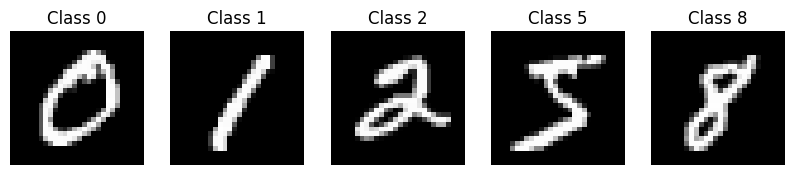

In [4]:
# 将图像与标签分开
images = torch.stack([img for img, _ in filtered_data])  # [N, 1, 28, 28]
labels = torch.tensor([label for _, label in filtered_data])  # [N]

classes = sorted(target_classes)
fig, axes = plt.subplots(1, len(classes), figsize=(10, 2))
for i, cls in enumerate(classes):
    idx = (labels == cls).nonzero(as_tuple=True)[0][0]
    axes[i].imshow(images[idx][0], cmap='gray')
    axes[i].set_title(f"Class {cls}")
    axes[i].axis('off')
plt.show()

按类组织为 {label: X} 形式

In [5]:
# 创建按类存储的字典
data_by_class = OrderedDict((label, []) for label in target_classes)

# 分类堆叠
for img, label in all_data:
    if label in target_classes:
        data_by_class[label].append(img.view(-1))  # 拉平为784维向量

# 将每类样本堆叠为一个Tensor
for label in data_by_class:
    data_by_class[label] = torch.stack(data_by_class[label])  # [Ni, 784]

# 查看结果
for label, X in data_by_class.items():
    print(f"Class {label}: {X.shape}")

Class 0: torch.Size([6903, 784])
Class 1: torch.Size([7877, 784])
Class 2: torch.Size([6990, 784])
Class 5: torch.Size([6313, 784])
Class 8: torch.Size([6825, 784])


### 计算类均值

In [6]:
def cal_mean(classes_dict):
    """
    计算各类均值与总均值，返回总均值与各类均值字典
    :param classes_dict: {label: X}形式的字典，X为同类数据按行堆叠
    :return: mean, means 总均值与各类均值字典
    """
    mean = 0
    means = {}
    N = 0
    for label, X in classes_dict.items():
        means[label] = torch.mean(X, dim=0, keepdim=True)
        mean += torch.sum(X, dim=0, keepdim=True)
        N += X.shape[0]
    mean /= N
    return mean, means

In [9]:
# 模拟数据
classes_dict = {
    0: torch.randn(10, 3),
    1: torch.randn(20, 3),
}

mean, means = cal_mean(classes_dict)
print("总均值:", mean.shape)
print("类均值:", {k: v.shape for k, v in means.items()})

总均值: torch.Size([1, 3])
类均值: {0: torch.Size([1, 3]), 1: torch.Size([1, 3])}


### 计算类内散度 Sw

In [10]:
def cal_Sw(classes_dict, means):
    """
    计算类内散度
    :param classes_dict:  {label: X}形式的字典，X为同类数据按行堆叠
    :param meams: {label: X}形式的字典，X为各类均值
    :return: Sw 类内散度
    """
    Sw = 0
    for label, X in classes_dict.items():
        Sw += (X - means[label]).T @ (X - means[label])
    
    return Sw

In [11]:
# 模拟 2 类数据
classes_dict = {
    0: torch.randn(5, 3),
    1: torch.randn(6, 3) + 1
}
means = {label: X.mean(dim=0, keepdim=True) for label, X in classes_dict.items()}

Sw = cal_Sw(classes_dict, means)
print(Sw.shape)
print(Sw)

torch.Size([3, 3])
tensor([[10.4598, -1.0910, -1.0547],
        [-1.0910,  4.4693, -6.0394],
        [-1.0547, -6.0394, 20.1379]])


### 计算类间散度 Sb

In [12]:
def cal_Sb(classes_dict, mean, means):
    """
    计算类间散度
    :param mean: 总均值
    :param means: {label: X} 形式的字典，X为各类均值
    :return: Sb 类间散度
    """
    Sb = 0
    for label, X in classes_dict.items():
        Sb += (means[label] - mean).T @ (means[label] - mean) * X.shape[0]
    
    return Sb

In [13]:
# ===== 模拟 3 个类别，每类 2 维特征 =====
torch.manual_seed(0)

# 每类随机生成若干点
X1 = torch.randn(5, 2) * 0.5 + torch.tensor([0., 0.])   # 类0，集中在(0,0)
X2 = torch.randn(6, 2) * 0.5 + torch.tensor([3., 3.])   # 类1，集中在(3,3)
X3 = torch.randn(4, 2) * 0.5 + torch.tensor([-3., 3.])  # 类2，集中在(-3,3)

classes_dict = {
    0: X1,
    1: X2,
    2: X3
}

# 计算每类均值
means = {label: X.mean(dim=0, keepdim=True) for label, X in classes_dict.items()}

# 计算总体均值
all_X = torch.cat(list(classes_dict.values()), dim=0)
mean = all_X.mean(dim=0, keepdim=True)
print("总体均值:\n", mean)

Sb = cal_Sb(classes_dict, mean, means)
print("\n类间散度矩阵 S_B:\n", Sb)
print("\n维度:", Sb.shape)

总体均值:
 tensor([[0.2057, 2.0522]])

类间散度矩阵 S_B:
 tensor([[79.8207,  7.5809],
        [ 7.5809, 33.7572]])

维度: torch.Size([2, 2])


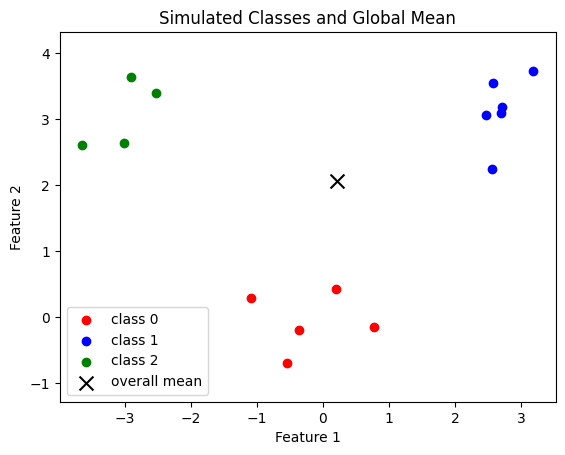

In [14]:
colors = ['red', 'blue', 'green']
for i, label in enumerate(classes_dict):
    plt.scatter(classes_dict[label][:,0], classes_dict[label][:,1], c=colors[i], label=f'class {label}')
plt.scatter(mean[0,0], mean[0,1], c='black', marker='x', s=100, label='overall mean')
plt.legend()
plt.title("Simulated Classes and Global Mean")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.axis('equal')
plt.show()

### 计算投影向量 W

In [15]:
def cal_W(Sw, Sb, r):
    """
    计算LDA投影向量矩阵 W
    :param Sw: 类内散度矩阵 (D, D)
    :param Sb: 类间散度矩阵 (D, D)
    :param r:  投影维度（通常 <= 类别数 - 1）
    :return: W 投影矩阵 (D, r)
    """
    # 为防止 Sw 不可逆或病态，先加一个微小正则项
    Sw_reg = Sw + 1e-6 * torch.eye(Sw.shape[0], device=Sw.device, dtype=Sw.dtype)

    # 计算广义特征值问题： Sw^{-1} Sb
    mat = torch.linalg.inv(Sw_reg) @ Sb

    # 求特征值与特征向量
    eigvals, eigvecs = torch.linalg.eig(mat)  # eigvecs: [D, D]

    # 只取实部（因为理论上结果应为实数）
    eigvals = eigvals.real
    eigvecs = eigvecs.real

    # 按特征值从大到小排序
    sorted_indices = torch.argsort(eigvals, descending=True)
    eigvals = eigvals[sorted_indices]
    eigvecs = eigvecs[:, sorted_indices]

    # 取前 r 个主投影向量
    W = eigvecs[:, :r]

    return W, eigvals[:r]

In [16]:
# 模拟数据
D = 4
Sw = torch.randn(D, D)
Sw = Sw.T @ Sw  # 保证对称正定
Sb = torch.randn(D, D)
Sb = Sb.T @ Sb  # 保证对称半正定

W, eigvals = cal_W(Sw, Sb, r=2)
print("W shape:", W.shape)
print("特征值:", eigvals)

W shape: torch.Size([4, 2])
特征值: tensor([1.7009e+03, 3.5307e-01])


计算相关数据

In [17]:
mean, means = cal_mean(data_by_class)
Sw = cal_Sw(data_by_class, means)
Sb = cal_Sb(data_by_class, mean, means)

### 投影到一维

投影向量形状: torch.Size([784, 1])
最大特征值: tensor(6.8410)


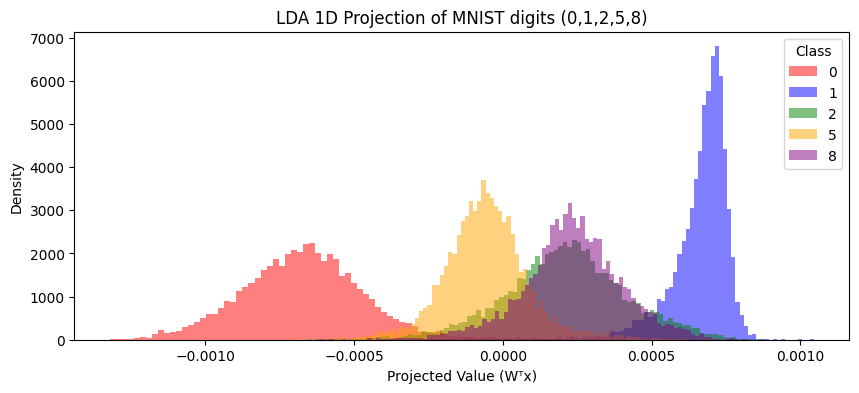

In [18]:
W, eigvals = cal_W(Sw, Sb, r=1)

print("投影向量形状:", W.shape)
print("最大特征值:", eigvals[0])

projected = OrderedDict()
for label, X in data_by_class.items():
    projected[label] = (X @ W).squeeze()  # [Ni]

plt.figure(figsize=(10, 4))
colors = ['red', 'blue', 'green', 'orange', 'purple']
for i, (label, values) in enumerate(projected.items()):
    plt.hist(values.numpy(), bins=100, alpha=0.5, color=colors[i], label=f'{label}', density=True)
plt.title('LDA 1D Projection of MNIST digits (0,1,2,5,8)')
plt.xlabel('Projected Value (Wᵀx)')
plt.ylabel('Density')
plt.legend(title='Class')
plt.show()

### 投影到二维

投影向量形状: torch.Size([784, 2])
前两个特征值: tensor([6.8410, 3.1007])


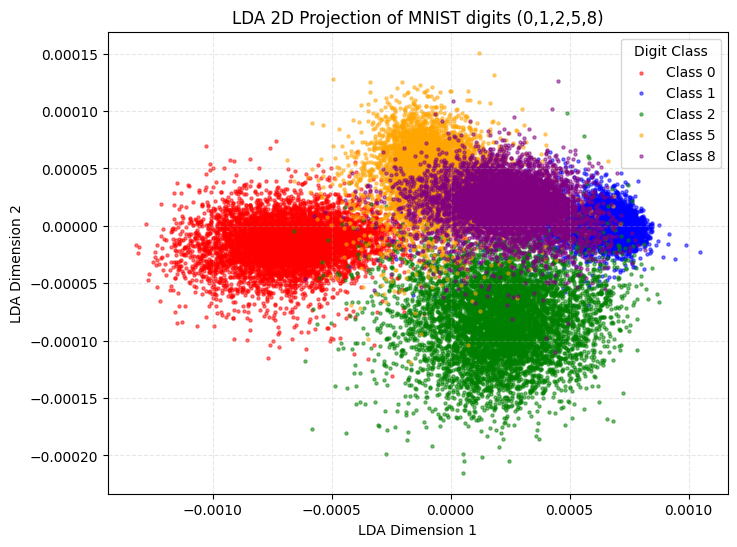

In [19]:
# 求二维投影方向
W, eigvals = cal_W(Sw, Sb, r=2)
print("投影向量形状:", W.shape)
print("前两个特征值:", eigvals[:2])

projected_2d = OrderedDict()
for label, X in data_by_class.items():
    projected_2d[label] = X @ W  # [Ni, 2]
    
plt.figure(figsize=(8, 6))
colors = ['red', 'blue', 'green', 'orange', 'purple']

for i, (label, values) in enumerate(projected_2d.items()):
    plt.scatter(values[:, 0].numpy(), values[:, 1].numpy(),
                s=5, alpha=0.5, color=colors[i], label=f'Class {label}')

plt.title('LDA 2D Projection of MNIST digits (0,1,2,5,8)')
plt.xlabel('LDA Dimension 1')
plt.ylabel('LDA Dimension 2')
plt.legend(title='Digit Class')
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()

### 投影到三维

投影向量形状: torch.Size([784, 3])
前两个特征值: tensor([6.8410, 3.1007, 2.4609])


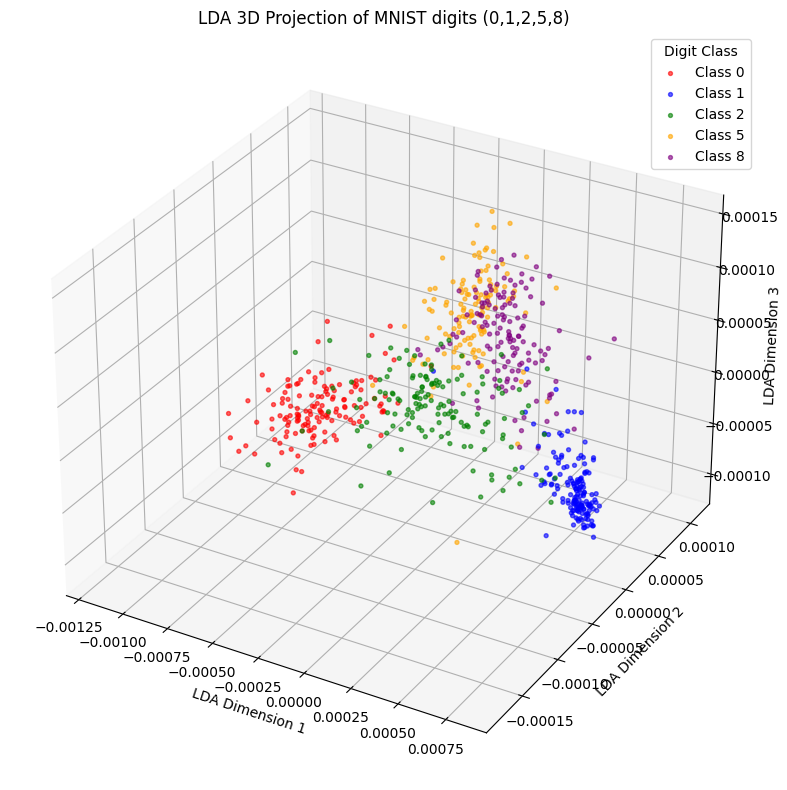

In [20]:
# 求二维投影方向
W, eigvals = cal_W(Sw, Sb, r=3)
print("投影向量形状:", W.shape)
print("前两个特征值:", eigvals[:3])

projected_3d = OrderedDict()
for label, X in data_by_class.items():
    projected_3d[label] = X @ W  # [Ni, 3]

from mpl_toolkits.mplot3d import Axes3D  # 3D绘图支持
import matplotlib.pyplot as plt

# 设置颜色（与之前一致）
colors = ['red', 'blue', 'green', 'orange', 'purple']

# 抽样（否则点太多，绘图会很慢）
sample_step = 50
sampled_projected = {label: X[::sample_step] for label, X in projected_3d.items()}

# 绘图
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

for i, (label, values) in enumerate(sampled_projected.items()):
    ax.scatter(values[:, 0].numpy(), values[:, 1].numpy(), values[:, 2].numpy(),
               s=8, alpha=0.6, color=colors[i], label=f'Class {label}')

ax.set_title('LDA 3D Projection of MNIST digits (0,1,2,5,8)')
ax.set_xlabel('LDA Dimension 1')
ax.set_ylabel('LDA Dimension 2')
ax.set_zlabel('LDA Dimension 3')
ax.legend(title='Digit Class')
plt.tight_layout()
plt.show()
